In [1]:
import numpy as np
import re, copy
from scipy.stats import linregress
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

# read and write itp forcefield file

In [69]:
# read itp file

def get_atom_para(ff_dict, ff_para):
    
    atom_types   = dict([[i[0],i[-2:]] for i in ff_dict["atomtypes"]])
    atom_type   = [i[1] for i in ff_dict["atoms"]]
    atom_name   = [i[4] for i in ff_dict["atoms"]]
    vdw_para    = np.array([[atom_types[i[1]] for i in ff_dict["atoms"]]], dtype=np.float32).tolist()
    atom_charge = np.array([i[-2] for i in ff_dict["atoms"]], dtype=np.float32).tolist()
    atom_mass   = np.array([i[-1] for i in ff_dict["atoms"]], dtype=np.float32).tolist()
    
    ff_para["vdw_para"]    = vdw_para[0]
    ff_para["atom_name"]   = atom_name
    ff_para["atom_type"]   = atom_type
    ff_para["mass"]        = atom_mass
    ff_para["charge"]      = atom_charge
    ff_para["mol_name"]    = ff_dict["moleculetype"][0][0]
    
    tmp_pairs = ff_dict.get("pairs", [])
    if ff_dict["pairs"] != []:
        tmp_pairs = np.array(ff_dict["pairs"], dtype=np.int32)        
        ff_para["pairs"]["type"]   = tmp_pairs[:,2].tolist()
        ff_para["pairs"]["pair"]   = tmp_pairs[:,:2].tolist()
    
    
    exclusions = ff_dict.get("exclusions", [])
    if exclusions != []:
        exclusions = [[int(j)for j in i] for i in exclusions]    
        ff_para["exclusions"] = exclusions
    
    return(ff_para)

def get_bond_para(ff_dict, ff_para):
    
    bond_type = np.array([i[2]  for i in ff_dict["bonds"]], dtype=np.int32).tolist()
    bond_pair = np.array([i[:2] for i in ff_dict["bonds"]], dtype=np.int32).tolist()
    bond_para = np.array([i[3:] for i in ff_dict["bonds"]], dtype=np.float32).tolist()
    
    ff_para["bonds"]["type"] = bond_type
    ff_para["bonds"]["pair"] = bond_pair
    ff_para["bonds"]["para"] = bond_para
    
    
    return(ff_para)
    

def get_angle_para(ff_dict, ff_para):
    
    if ff_dict.get("angles", False) :
        angle_type = np.array([i[3]  for i in ff_dict["angles"]], dtype=np.int32).tolist()
        angle_pair = np.array([i[:3] for i in ff_dict["angles"]], dtype=np.int32).tolist()
        angle_para = np.array([i[4:] for i in ff_dict["angles"]], dtype=np.float32).tolist()


        ff_para["angles"]["type"] = angle_type
        ff_para["angles"]["pair"] = angle_pair
        ff_para["angles"]["para"] = angle_para
    
    return(ff_para)

def get_dihe_para(ff_dict, ff_para):
    
    if ff_dict.get("dihedrals", False) :

        tmp_order = ["1", "2", "3", "4", "6"]
        dihe_line = copy.deepcopy(ff_dict["dihedrals"])

        tmp_line = [i[:5] + [i[-1]]  for i in dihe_line if i[4]=="9"]

#         for line in tmp_line:
#             for i in tmp_order:
#                 if line[4] == "9" and not line[:5] +[i] in tmp_line :
#                     dihe_line.append(line[:5] + ["0.0", "0.0"] +[i])
#                     tmp_line.append(line[:5] + [i] )


        dihe_line = sorted(dihe_line, key=lambda x : " ".join(x[:5]+[x[-1]])) 


        dihe_type  = np.array([i[4]    for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()
        dihe_pair  = np.array([i[:4]   for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()
        dihe_para  = np.array([i[5:-1] for i in dihe_line if i[4]=="9" ], dtype=np.float32).tolist()
        dihe_order = np.array([i[-1]   for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()

        impo_type  = np.array([i[4]    for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist()    
        impo_pair  = np.array([i[:4]   for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist()
        impo_para  = np.array([i[5:-1] for i in dihe_line if i[4]!="9" ], dtype=np.float32).tolist()
        impo_order = np.array([i[-1]   for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist() 

    
        ff_para["dihedrals"]["type"]  = dihe_type 
        ff_para["dihedrals"]["pair"]  = dihe_pair 
        ff_para["dihedrals"]["para"]  = dihe_para 
        ff_para["dihedrals"]["order"] = dihe_order

        ff_para["impropers"]["type"]  = impo_type 
        ff_para["impropers"]["pair"]  = impo_pair 
        ff_para["impropers"]["para"]  = impo_para 
        ff_para["impropers"]["order"] = impo_order
    

    return(ff_para)

def get_pos_restrain_para(ff_dict, ff_para):
    
    if ff_dict.get("position_restraints", False) :
        pos_restrain_line = copy.deepcopy(ff_dict["position_restraints"])

        atom_id  = [int(i[0]) for i in pos_restrain_line ]
        pos_type = [int(i[1]) for i in pos_restrain_line ]
        pos_para = [[flost(j) for j in i[2:]] for i in pos_restrain_line ]

        ff_dict["position_restraints"]["type"] = pos_type
        ff_dict["position_restraints"]["id"]   = atom_id 
        ff_dict["position_restraints"]["para"] = pos_para
    
    return(ff_dict)

def itp_read(itp_file, ff_type = "gaff"):
    
    itp_txt = open(itp_file, "r").read()
    itp_txt = re.sub(';.*', '' , itp_txt)
    itp_txt = re.sub('[\[\]]', '' , itp_txt)

    itp_line = itp_txt.split("\n")
    
    part_list = ["atomtypes", "moleculetype", "atoms","bonds","pairs","angles",
                 "dihedrals", "exclusions", "" ]
    
    ff_dict = {"atomtypes":[], "moleculetype":[], "atoms":[],     "bonds":[],
               "pairs":[],     "angles":[],       "dihedrals":[],  "exclusions":[], # "position_restraints":[]
              }
    
    addition_part = []
    for line in itp_line:
        line_split = line.split()
        
        if len(line_split) == 1 :
            part = line_split[0].lower()
        elif len(line_split) > 0 and part in part_list :
            ff_dict[part].append(line_split)
        elif len(line_split) > 0 and part not in part_list :
            addition_part.append(line)

    ff_para = {"vdw_para":[], "bonds":{}, "angles":{}, "dihedrals":{},
               "impropers":{}, "pairs":{}, "mol_name":"", "ff_type":"gaff","charge":[],"mass":[],
               "atom_type":[],"atom_name":[], "exclusions":[],
               "position_restraints":[]}
    
    ff_para["addition_part"] = addition_part

    ff_para = get_atom_para(ff_dict,  ff_para)
    ff_para = get_bond_para(ff_dict,  ff_para)
    ff_para = get_angle_para(ff_dict, ff_para)
    ff_para = get_dihe_para(ff_dict,  ff_para)
    #ff_para = get_pos_restrain_para(ff_dict, ff_para)
    ff_para["ff_type"] = ff_type
    
    return(ff_para)

# write itp file

def get_moleculetype_line(ff_para):
    
    moleculetype = [ "[ moleculetype ]",
                     " ;name            nrexcl",
                     "   %s              3" %(ff_para["mol_name"])]
    
    moleculetype = "\n".join(moleculetype)
    
    return(moleculetype)

def get_atomtypes_line(ff_para):
    
    atom_type   = ff_para["atom_type"]
    vdw_para    = ff_para["vdw_para"]

    
    txt = ["[ atomtypes ]",
           ";name   bond_type     mass     charge   ptype   sigma         epsilon       Amb"]
    
    
    for n in range(len(atom_type)):   
        tmp_line = " %5s %5s          0.000      0.000    A   %10.7f  %10.7f " %(atom_type[n], atom_type[n],
                                                                                  vdw_para[n][0], vdw_para[n][1])
        if not tmp_line in txt:
            txt.append(tmp_line)
        
    return(txt)

def get_atom_line(ff_para):
    
    atom_type   = ff_para["atom_type"]
    atom_name   = ff_para["atom_name"]
    atom_mass   = ff_para["mass"]
    atom_charge = ff_para["charge"]
    mol_title   = ff_para["mol_name"]
    
    txt = ["[ atoms ]",
           ";   nr   type  resi   res  atom  cgnr     charge      mass"]
    
    
    for n in range(len(ff_para["mass"])):        
        

        
        tmp_line = " %5d %5s %5d  %5s%5s %5d   %10.7f  %10.7f " %(n+1,atom_type[n], 1, mol_title, atom_name[n],
                                                                 n, atom_charge[n], atom_mass[n])
        txt.append(tmp_line)
        
    return("\n".join(txt))

def get_bond_line(ff_para):
    
    txt = ["[ bonds ]",
           " ;   ai   aj   funct     r          k"]

    if ff_para.get("bonds", {}) != {}:
        atom_name  = ff_para["atom_name"]
        bond_type  = ff_para["bonds"]["type"]
        bond_pair  = ff_para["bonds"]["pair"]
        bond_para  = ff_para["bonds"]["para"]       
    
        
        for n in range(len(bond_pair)):
            
            tmp_pair   = bond_pair[n]
            bond_atom  = "%s - %s" %(atom_name[tmp_pair[0] - 1], atom_name[tmp_pair[1] - 1])
            tmp_line = "  %4d %4d   %4d    %8.6f   %e  ; %s" %(tmp_pair[0], tmp_pair[1],bond_type[n],
                                                               bond_para[n][0], bond_para[n][1],
                                                               bond_atom)
            txt.append(tmp_line)

    return("\n".join(txt))

def get_angle_line(ff_para):
    
    
    txt = ["[ angles ]",
           ";   ai   aj  ak    funct    theta          cth"]

    if ff_para.get("angles", {}) != {}:
        atom_name   = ff_para["atom_name"]
        angle_type  = ff_para["angles"]["type"]
        angle_pair  = ff_para["angles"]["pair"]
        angle_para  = ff_para["angles"]["para"]


        for n in range(len(angle_type)):

            tmp_pair   = angle_pair[n]
            angle_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])

            tmp_line = "  %4d %4d %4d %4d    %e   %e  ; %s" %tuple(tmp_pair + [angle_type[n]] +
                                                               angle_para[n] + [angle_atom])
            txt.append(tmp_line)
    return("\n".join(txt))

def get_dihe_line(ff_para):

    txt = ["[ dihedrals ] ; propers",
           ";    i   j    k    l   func     phase          kd         pn"]
    if ff_para.get("dihedrals", {}) != {}:
        atom_name  =  ff_para["atom_name"]
        dihe_type  =  ff_para["dihedrals"]["type"]  
        dihe_pair  =  ff_para["dihedrals"]["pair"]  
        dihe_para  =  ff_para["dihedrals"]["para"]  
        dihe_order =  ff_para["dihedrals"]["order"] 

        for n in range(len(dihe_order)):

            tmp_pair   = dihe_pair[n]
            dihe_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])

            tmp_line = "  %4d %4d %4d %4d %4d   %e   %e  %d  ; %s" %tuple(tmp_pair + [dihe_type[n]] +
                                                                          dihe_para[n] + [dihe_order[n], dihe_atom])
            txt.append(tmp_line)
    
    return("\n".join(txt))

def get_impo_line(ff_para):
    
    txt = ["[ dihedrals ] ; impropers",
           ";    i   j    k    l   func     phase          kd         pn"]


    if ff_para.get("impropers", {}) != {}:
        atom_name  =  ff_para["atom_name"]
        impo_type  =  ff_para["impropers"]["type"]   
        impo_pair  =  ff_para["impropers"]["pair"]   
        impo_para  =  ff_para["impropers"]["para"]   
        impo_order =  ff_para["impropers"]["order"]  
        
       
        for n in range(len(impo_order)):
            
            tmp_pair   = impo_pair[n]
            impo_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])
            
            tmp_line = "  %4d %4d %4d %4d %4d   %e   %e  %d  ; %s" %tuple(tmp_pair + [impo_type[n]] +
                                                                          impo_para[n] + [impo_order[n], impo_atom])
            txt.append(tmp_line)
    
    return("\n".join(txt))

def get_pairs_line(ff_para):

    txt = ["[ pairs ]",
           ";   ai     aj    funct "]

    if ff_para.get("pairs", {}) != {}:
        atom_name = ff_para["atom_name"]
        pair_type = ff_para["pairs"]["type"]
        pair_pair = ff_para["pairs"]["pair"]
        
    
        
        for n in range(len(pair_type)):
            
            tmp_pair   = pair_pair[n]
            pair_atom  = "%s - %s" %(atom_name[tmp_pair[0] - 1], atom_name[tmp_pair[1] - 1])
            tmp_line = "  %4d  %4d   %4d    ; %s" %(tmp_pair[0], tmp_pair[1], pair_type[n], pair_atom)
            txt.append(tmp_line)

    return("\n".join(txt))

def get_exclusions_line(ff_para):

    txt = ["[ exclusions ]",
          "; i  j"]

    if ff_para.get("exclusions", {}) != {}:
        exclusions = ff_para["exclusions"]
        exclusions = [[str(j)for j in i]for i in exclusions]    



        for i in exclusions:
            tmp_line = "  ".join(i)
            txt.append(tmp_line)
    
    return("\n".join(txt))

def get_pos_restraint_line(para):
    pos_restraint_line = ["[ position_restraints ]",
                          "; atom  type  fx    fy   fz"]
    for i in para:
       pos_restraint_line.append("  %d  %d   %f    %f    %f" %tuple(i)) 
    
    pos_restraint_str = "\n".join(pos_restraint_line)
    return(pos_restraint_str)

def get_itp_line(ff_para, pos_restraint = None, write_atomtypes = False):
    
    moleculetype_line = get_moleculetype_line(ff_para)
    atomtypes_line    = get_atomtypes_line(ff_para)    
    atom_line         = get_atom_line(ff_para)
    bond_line         = get_bond_line(ff_para)
    angle_line        = get_angle_line(ff_para)
    dihe_line         = get_dihe_line(ff_para)
    impo_line         = get_impo_line(ff_para)
    pairs_line        = get_pairs_line(ff_para)
    exclusions_line   = get_exclusions_line(ff_para)
    
    

    if pos_restraint:
        pos_restraint_line = get_pos_restraint_line(pos_restraint)
    else:
        pos_restraint_line = ""
    
    ff_type = ff_para.get("ff_type","gaff")
    if ff_type == "gaff" :
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        2          yes        0.5      0.8333"]
    elif ff_type == "opls":
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        3          yes        0.5      0.5"]
    
    default_line = "\n".join(default_line)
    atomtypes_line = "\n".join(atomtypes_line)

    addition_line = "\n".join(ff_para["addition_aprt"])
                    

    if write_atomtypes:
        itp_txt = [default_line      ,
                   moleculetype_line ,
                   atomtypes_line    ,
                   atom_line         ,
                   bond_line         ,
                   angle_line        ,
                   dihe_line         ,
                   impo_line         ,
                   pairs_line        ,
                   exclusions_line   ,
                   addition_line,     ]
    else:
        itp_txt = [moleculetype_line ,
                   atom_line         ,
                   pos_restraint_line,
                   bond_line         ,
                   angle_line        ,
                   dihe_line         ,
                   impo_line         ,
                   pairs_line        ,
                   exclusions_line   ,
                   addition_line,     ]
        
        
    itp_txt = "\n\n".join(itp_txt)
    
    return(itp_txt)

# write top file

def write_top(structure, ff_para_list, pos_restraint = None, write_itp = True):
    
    mol_types = structure.mol_types
    
    mol_list = [mol_types[0]]
    mol_num  = [1]
    for i in mol_types[1:]:
        if i == mol_list[-1]:
            mol_num[-1] = mol_num[-1] + 1
        else:
            mol_list.append(i)
            mol_num.append(1)
            
    
    ff_type = list(set([ff_para.get("ff_type","gaff") for ff_para in ff_para_list]))
    assert len(ff_type) == 1, "Forcefield types should be same."
    ff_type = ff_type[0]

    if ff_type == "gaff" :
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        2          yes        0.5      0.8333"]
    elif ff_type == "opls":
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        3          yes        0.5      0.5"]
    default_line = "\n".join(default_line)


    atomtypes_line = ["[ atomtypes  ]",
                      ";   nr   type  resi   res  atom  cgnr     charge      mass"]
    
    include_line = ["; Include itp topology file"]

    mol_restrant_list = list(pos_restraint.keys()) if pos_restraint else []
    for ff_para in ff_para_list:
        if pos_restraint and ff_para["mol_name"] in mol_restrant_list:            
            restraint_para = pos_restraint[ff_para["mol_name"]]
        else:
            restraint_para = None
        include_line.append('#include "%s.itp" '  %(ff_para["mol_name"]))
        itp_file = open("%s.itp" %(ff_para["mol_name"]), "w")
        itp_file.write(get_itp_line(ff_para, pos_restraint = restraint_para, write_atomtypes = False))
        itp_file.close()
        
        atomtypes_line = atomtypes_line + get_atomtypes_line(ff_para)[2:]
    
    atomtypes_line = "\n".join(atomtypes_line)
    include_line = "\n".join(include_line)
    
    system_line = ["[ system ]",
                   "system"     ] 
    
    system_line = "\n".join(system_line)
    
    molecules_line = ["[ molecules ]",
                      "; Compound        nmols", ]
    
        
    for mol_type, mol_num in zip(mol_list, mol_num )  :
        molecules_line.append("  %s              %d" %(mol_type, mol_num ))
    
        
    molecules_line = "\n".join(molecules_line)
    

    top_line = [default_line,
                atomtypes_line,
                include_line,
                system_line,
                molecules_line,

               ]

    top_line = "\n\n".join(top_line)
    
    topology_file = open("topol.top", "w")
    
    topology_file.write(top_line)
    topology_file.close()


# energy and parameter gradient calculation

In [70]:
# energy item calculation
def bond_feature(coord, bond_idx):
    bond_value = np.linalg.norm(coord[:, bond_idx[:,0]] - coord[:, bond_idx[:,1]], axis=-1)
    return(bond_value)

def angle_feature(coord, angle_idx):
    v1 = coord[:, angle_idx[:,0]] - coord[:, angle_idx[:,1]]
    v2 = coord[:, angle_idx[:,2]] - coord[:, angle_idx[:,1]]
    theta = np.arccos(np.sum(v1*v2, axis=-1) / (np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1)))
    return(theta)

def bond(k, b, coord1, coord2):
    
    v1 = coord1 - coord2
    r = np.linalg.norm(v1)
    dr = r - b
    
    e_bond = k*dr**2
    
    # force 
    f_bond= 2.0*k*dr/r
    
    f_1=   v1*f_bond
    f_2= - v1*f_bond

    # parameter gradient
    # dE/dk = (x-b)^2
    grad_k = dr**2 
    
    # dE/db = -2k(x-b)    
    grad_b = -2*k*dr 

    return(e_bond, [grad_k, grad_b],[-f_1, -f_2],[-f_1/k, -f_2/k])

def angle(k, b, coord1, coord2, coord3):
    
    v1 = coord1 - coord2
    v2 = coord3 - coord2
    
    len1 = np.linalg.norm(v1)
    len2 = np.linalg.norm(v2)
    
    cos_A = np.sum(v1*v2) / (len1* len2)
    if   cos_A >  0.99999 :
         cos_A =  0.99999
    elif cos_A < -0.99999 :
         cos_A = -0.99999
    
    dA = np.arccos(cos_A) - b
    
    e_angle = k*dA**2
    
    # force
    sin_A2 = 1 - cos_A**2
    f_angle = -2*k*dA/sin_A2**0.5
    
    a11=cos_A*f_angle/len1**2
    a12=     -f_angle/len1/len2
    a22=cos_A*f_angle/len2**2
    
    f1=a11*v1+a12*v2      
    f3=a22*v2+a12*v1  
    
    f_1=f1
    f_2=-f1-f3
    f_3=f3
    
    
    # parameter gradient    
    # dE/dk = (x-b)^2
    grad_k = dA**2 
    
    # dE/db = -2k(x-b)    
    grad_b = -2*k*dA 

    return(e_angle, [grad_k, grad_b], [f_1, f_2, f_3], [f_1/k, f_2/k, f_3/k])

def dihe(k, b, n, coord1, coord2, coord3, coord4):
    
    v12    = coord2 - coord1
    v13    = coord3 - coord1
    v23    = coord3 - coord2
    v34    = coord4 - coord3
    v123   = np.cross(v12, v23)
    v234   = np.cross(v23, v34)
    v1234  = np.cross(v123, v234)

    r23 = np.linalg.norm(v23);
    f2  = np.dot(v123, v234);

    phi = np.arctan2(np.dot(v1234, v23), r23 * f2)
    
    
    dphi = phi*n - b
    e_dihe = (1.0+np.cos(dphi))*k
    
    
    # force
    
    scale = -1* n * k * np.sin(dphi)
    
    dot = np.dot(v123, v34);
    f1 = r23 * dot
    f1_f2 = f1 * f1 + f2 * f2
    c1 =  f2 / f1_f2
    c2 = -f1 / f1_f2
    
    t = c1 * r23;
    tmp = np.cross(v23, v234);
    g1 = -(t * v234 + c2 * tmp);


    tmp = np.cross(v13, v34)
    g3  = np.cross(v13, v234)
    g4  = np.cross(v123, v34)
    t = dot / r23;
    g2 = -(c1 * (t * v23 - r23 * tmp) + c2 * (-g3 - g4))

    t = c1 * -r23;
    tmp = np.cross(v123, v23)
    g4 = -(t * v123 - c2 * tmp)
    
    g3 = -g1 - g2 - g4;
    
    f1= g1 * scale;
    f2= g2 * scale;
    f3= g3 * scale;
    f4= g4 * scale;

    
    # parameter gradient
    grad_k = 1.0  + np.cos(dphi)
    grad_b =  np.sin(dphi)*k
    
    return(e_dihe,[grad_k, grad_b], [-f1,-f2,-f3,-f4], [-f1/k,-f2/k,-f3/k,-f4/k])

def imph(k, b,  coord1, coord2, coord3, coord4):

    v12    = coord2 - coord1
    v13    = coord3 - coord1
    v23    = coord3 - coord2
    v34    = coord4 - coord3
    v123   = np.cross(v12, v23)
    v234   = np.cross(v23, v34)
    v1234  = np.cross(v123, v234)

    r23 = np.linalg.norm(v23);
    f2  = np.dot(v123, v234);

    phi = np.arctan2(np.dot(v1234, v23), r23 * f2)  
    
    
    dphi = phi - b
    e_imph = k * dphi**2
    
    # force
    
    cos_phi = f2 / np.linalg.norm(v123) / np.linalg.norm(v234);
    sin_phi = np.linalg.norm(v23) / np.linalg.norm(v123) / np.linalg.norm(v234) * np.dot(v123, v34) ;

    cos_delta = cos_phi * np.cos(b) + sin_phi * np.sin(b);
    sin_delta = sin_phi * np.cos(b) - cos_phi * np.sin(b);

    p = sin_delta;
    if cos_delta > 1.0 : 
        p = np.arcsin(sin_delta)
    else:
        if cos_delta < -1.0:
            cos_delta = -1.0
        p = np.arccos(cos_delta);
        if sin_delta < 0.0:
            p = -p
            

    scale = 2* k * p
    
    dot = np.dot(v123, v34);
    f1 = r23 * dot
    f1_f2 = f1 * f1 + f2 * f2
    c1 =  f2 / f1_f2
    c2 = -f1 / f1_f2
    
    t = c1 * r23;
    tmp = np.cross(v23, v234);
    g1 = -(t * v234 + c2 * tmp);


    tmp = np.cross(v13, v34)
    g3  = np.cross(v13, v234)
    g4  = np.cross(v123, v34)
    t = dot / r23;
    g2 = -(c1 * (t * v23 - r23 * tmp) + c2 * (-g3 - g4))

    t = c1 * -r23;
    tmp = np.cross(v123, v23)
    g4 = -(t * v123 - c2 * tmp)
    
    g3 = -g1 - g2 - g4;
    
    f1= g1 * scale;
    f2= g2 * scale;
    f3= g3 * scale;
    f4= g4 * scale;
    
    
    # grad
    grad_k = dphi**2
    grad_b = -2*k*dphi
    
    return(e_imph, [grad_k, grad_b], [-f1,-f2,-f3,-f4], [-f1/k,-f2/k,-f3/k,-f4/k])

def coul(q1, q2, coord1, coord2, scale_factor = 1.0, cutoff=12.):
    
    v1 = coord1-coord2
    r = np.linalg.norm(v1)
    e_coul = 0.0
    f1, f2 = 0.0, 0.0
    grad_q1, grad_q2 = 0.0, 0.0
    if r < cutoff:
        q1q2 = 96.485 * 27.211 * 0.5291774 *  q1 * q2 
        e_coul = q1q2 *  1. / r  * scale_factor        
    
        fswitch = -1. * q1q2 *  scale_factor * 1. / r**2
    
        f1 =  v1 / r * fswitch
        f2 = -v1 / r * fswitch

        # parameter gradient

        grad_q1 = e_coul / q1
        grad_q2 = e_coul / q2
    
    return(e_coul, [grad_q1, grad_q2], [-f1, -f2], [-f1/q1,-f1/q2,-f2/q1,-f2/q2])

def vdw(epsilon1, sigma1, epsilon2, sigma2, coord1, coord2,  scale_factor = 1.0, cutoff=12.):
    
    v12 = coord1 - coord2
    r1  = np.linalg.norm(v12)
    
    sigma12   = (sigma1 + sigma2)/2
    epsilon12 = (epsilon1*epsilon2)**0.5
    
    
    e_vdw  = 0.
    dsigma1 = 0.
    depsilon1 = 0.
    dsigma2 = 0.
    depsilon2 = 0.
    f1,f2 = 0.0,0.0
    f1_depsilon1 = 0.
    f1_depsilon2 = 0.
    f2_depsilon1 = 0.
    f2_depsilon2 = 0.
    f1_dsigma1   = 0.
    f1_dsigma2   = 0.
    f2_dsigma1   = 0.
    f2_dsigma2   = 0.
    if r1 <= cutoff:

        e_vdw =  4*epsilon12 * (((sigma12/r1    )**12  - (sigma12/r1    )**6 ))
        
        
        dr =  4*epsilon12 * ((sigma12/r1    )**12 * -12 - (sigma12/r1    )**6 * -6  ) / r1
        
        dsigma    = 4*epsilon12 * (((sigma12/r1    )**12*12        - (sigma12/r1    )**6*6 ) ) / sigma12
        dr_sigma  = 4*epsilon12 * ((sigma12/r1    )**12 * -12*12   - (sigma12/r1    )**6 * -6*6  ) / r1 /sigma12

        # force
    
        f1 =  v12 / r1 * dr * scale_factor
        f2 = -v12 / r1 * dr * scale_factor
        
        e_vdw = e_vdw * scale_factor
        # parameter gradient
        depsilon1 = -e_vdw /  epsilon1 / 2
        depsilon2 = -e_vdw /  epsilon2 / 2 
        
        dsigma1 = dsigma * scale_factor
        dsigma2 = dsigma * scale_factor
        
        
        # force parameter gradient
        
        f1_depsilon1 = -f1 /  epsilon1 / 2
        f1_depsilon2 = -f1 /  epsilon2 / 2 
        
        f2_depsilon1 = -f2 /  epsilon1 / 2
        f2_depsilon2 = -f2 /  epsilon2 / 2 
        
        f1_dsigma1 = -dr_sigma*v12 / r1 * scale_factor
        f1_dsigma2 = -dr_sigma*v12 / r1 * scale_factor
        
        f2_dsigma1 = -f1_dsigma1
        f2_dsigma2 = -f1_dsigma2
        
        
    return(e_vdw, [[depsilon1, dsigma1], [depsilon2, dsigma2]],[-f1,-f2],
                    [f1_depsilon1,f1_depsilon2,f2_depsilon1,f2_depsilon2],
                   [f1_dsigma1,f1_dsigma2,f2_dsigma1,f2_dsigma2])
        

# forcefield optimizing

In [58]:
# force and gradient

def get_e_f_g(coords, ff, cutoff=12.0):
   
    # itp atom index start form 1
    bond_idx  = np.array(ff["bonds"]["pair"])      - 1 
    angle_idx = np.array(ff["angles"]["pair"])     - 1 
    dihe_idx  = np.array(ff["dihedrals"]["pair"])  - 1 
    ipmh_idx  = np.array(ff["impropers"]["pair"])  - 1    
    
    bond_param     = np.array(ff["bonds"]["para"] )
    angle_param    = np.array(ff["angles"]["para"] )
    dihe_param     = np.array(ff["dihedrals"]["para"] )
    dihe_order     = np.array(ff["dihedrals"]["order"])
    ipmh_param     = np.array(ff["impropers"]["para"])
  
    charge         = np.array(ff["charge"])
    sigma, epsilon = np.array(ff["vdw_para"]).T
    sigma = sigma * 10
    
    # the unit of nonbond distance is angstrom
    mol_atom_num = len(ff["charge"])
    
    # the bond pairs is the 1-2 pairs
    # the 1-3 pairs are the atoms connected by the center atoms in angle items
    # pair 1-4
    pair_14      = np.array(ff["pairs"]["pair"]) -1 
    # make sure the first atom index of the pair is larger then the second one
    mask = pair_14[:,0] > pair_14[:,1]
    pair_14[mask] = pair_14[mask][:,::-1]
    pair14    = pair_14.tolist() 

    # pair 1-2, 1-3
    pair_1213    = np.array(ff["bonds"]["pair"] + [[i[0],i[2]] for i in ff["angles"]["pair"]]) - 1
    # make sure the first atom index of the pair is larger then the second one
    mask = pair_1213[:,0] > pair_1213[:,1]
    pair_1213[mask] = pair_1213[mask][:,::-1] 
    pair1213    = pair_1213.tolist()
    
    # energy and force of bond items
    e_bond = 0.
    f_bond = np.zeros(len(coords)*3).reshape((-1,3))
    g_bond = []
    f_g_bond = []
    for i,j in zip(bond_param, bond_idx) :

        tmp = bond(i[1]/200, i[0]*10, coords[j[0]], coords[j[1]])
        e_bond += tmp[0]
        g_bond.append(tmp[1])
        f_bond[j[0]] +=  tmp[2][0]
        f_bond[j[1]] +=  tmp[2][1]
        f_g_bond.append(tmp[3])
        
    
    # energy and force of angle items
    e_angle = 0.
    f_angle = np.zeros(len(coords)*3).reshape((-1,3))
    g_angle = []
    f_g_angle = []

    for i,j in zip(angle_param, angle_idx) :
        tmp = angle(i[1]/2, i[0]/180*np.pi, coords[j[0]], coords[j[1]], coords[j[2]])
        e_angle += tmp[0]
        f_angle[j[0]] +=  tmp[2][0]
        f_angle[j[1]] +=  tmp[2][1]
        f_angle[j[2]] +=  tmp[2][2]
        g_angle.append(tmp[1])
        
        f_g_angle.append(tmp[3])
        
    # energy and force of dihedral items
    e_dihe = 0.
    f_dihe = np.zeros(len(coords)*3).reshape((-1,3))
    g_dihe = []
    f_g_dihe = []

    for i,j,k in zip(dihe_param, dihe_idx, dihe_order) :
        tmp = dihe(i[1], i[0]/180*np.pi, k, coords[j[0]], coords[j[1]], coords[j[2]], coords[j[3]])
        e_dihe += tmp[0]
        f_dihe[j[0]] +=  tmp[2][0]
        f_dihe[j[1]] +=  tmp[2][1]
        f_dihe[j[2]] +=  tmp[2][2]
        f_dihe[j[3]] +=  tmp[2][3]
        g_dihe.append(tmp[1])
        
        f_g_dihe.append(tmp[3])

        
    # energy and force of improper items
    e_imph = 0.
    f_imph = np.zeros(len(coords)*3).reshape((-1,3))
    g_imph = []
    f_g_imph = []
    for i,j in zip(ipmh_param, ipmh_idx) :
        tmp = imph(i[1]/2, i[0]/180*np.pi, coords[j[0]], coords[j[1]], coords[j[2]], coords[j[3]])
        e_imph += tmp[0]
        f_imph[j[0]] +=  tmp[2][0]
        f_imph[j[1]] +=  tmp[2][1]
        f_imph[j[2]] +=  tmp[2][2]
        f_imph[j[3]] +=  tmp[2][3]
        g_imph.append(tmp[1])
        
        f_g_imph.append(tmp[3])
        
        
    # energy and force of nonbond items
    e_coul = 0.
    f_coul = np.zeros(len(coords)*3).reshape((-1,3))
    g_coul = np.zeros(len(coords))
    f_g_coul = np.zeros((len(coords),len(coords),3))
    
    
    e_vdw = 0.
    f_vdw = np.zeros(len(coords)*3).reshape((-1,3))
    g_vdw = np.zeros(len(coords)*2).reshape((-1,2))
    f_g_vdw_epsilon = np.zeros((len(coords),len(coords),3))
    f_g_vdw_sigma   = np.zeros((len(coords),len(coords),3))
    

    for i in range(len(coords)) :
        for j in range(i+1, len(coords)) :
            if [i,j] in pair14:
                tmp1 = coul(charge[i], charge[j], coords[i], coords[j], cutoff=cutoff, scale_factor=0.8333333)
                tmp2 = vdw(epsilon[i], sigma[i], epsilon[j], sigma[j], coords[i], coords[j],  
                           scale_factor = 0.5, cutoff=cutoff)      
            elif [i,j] not in pair1213:
                tmp1 = coul(charge[i], charge[j], coords[i], coords[j], cutoff=cutoff, scale_factor=1.0)
                tmp2 = vdw(epsilon[i], sigma[i], epsilon[j], sigma[j], coords[i], coords[j],  
                           scale_factor = 1.0, cutoff=cutoff)
            else:
                continue
            e_coul += tmp1[0]
            f_coul[i] +=  tmp1[2][0]
            f_coul[j] +=  tmp1[2][1]
            g_coul[i] +=  tmp1[1][0]
            g_coul[j] +=  tmp1[1][1]
            
            f_g_coul[i,i] += tmp1[3][0]
            f_g_coul[i,j] += tmp1[3][1]
            f_g_coul[j,i] += tmp1[3][2]
            f_g_coul[j,i] += tmp1[3][3]
            
            e_vdw += tmp2[0]
            f_vdw[i] +=  tmp2[2][0]
            f_vdw[j] +=  tmp2[2][1]
            g_vdw[i] +=  np.array(tmp2[1][0])
            g_vdw[j] +=  np.array(tmp2[1][1])
            
            f_g_vdw_epsilon[i,i] += tmp2[3][0]
            f_g_vdw_epsilon[i,j] += tmp2[3][1]
            f_g_vdw_epsilon[j,i] += tmp2[3][2]
            f_g_vdw_epsilon[j,i] += tmp2[3][3]
            
            
            f_g_vdw_sigma[i,i] += tmp2[3][0]
            f_g_vdw_sigma[i,j] += tmp2[3][1]
            f_g_vdw_sigma[j,i] += tmp2[3][2]
            f_g_vdw_sigma[j,i] += tmp2[3][3]
        
    # total energy 
    e_total = e_bond + e_angle + e_dihe + e_imph + e_coul + e_vdw
    # total force
    f_total = f_bond + f_angle + f_dihe + f_imph + f_coul + f_vdw
    # gradient of energy
    g_total = [np.array(g_bond)[:,0], np.array(g_angle)[:,0], np.array(g_dihe)[:,0], np.array(g_imph)[:,0], 
               g_coul, g_vdw[:,0],  g_vdw[:,1]]
    # gradient of force
    f_g_total = [f_g_bond,f_g_angle, f_g_dihe, f_g_imph, f_g_coul,  f_g_vdw_epsilon, f_g_vdw_sigma]
    return(e_total, f_total, g_total, f_g_total)

def get_g(delta_e, delta_f, g, f_g, ff, force_weight=0.001):
    
    # gradient of energy
    g_total = np.hstack(g)*delta_e    
    
    # gradient of force
    f_g_bond, f_g_angle, f_g_dihe, f_g_imph, f_g_coul,  f_g_vdw_epsilon, f_g_vdw_sigma = f_g
    

    bond_idx  = np.array(ff["bonds"]["pair"])      - 1 
    angle_idx = np.array(ff["angles"]["pair"])     - 1 
    dihe_idx  = np.array(ff["dihedrals"]["pair"])  - 1 
    ipmh_idx  = np.array(ff["impropers"]["pair"])  - 1      
    
    # force difference
    tmp_f  = np.hstack([delta_f[bond_idx[:,0]], delta_f[bond_idx[:,1]]])   
    
    # gradient contribution of bond
    g_bond = np.array(f_g_bond).reshape((-1,6)) * tmp_f
    g_bond = np.sum(g_bond,axis=1)
    
    # gradient contribution of angle
    tmp_f  = np.hstack([delta_f[angle_idx[:,0]], delta_f[angle_idx[:,1]], delta_f[angle_idx[:,2]]]) 
    g_angle = np.array(f_g_angle).reshape((-1,9)) * tmp_f
    g_angle = np.sum(g_angle,axis=1)
    
    # gradient contribution of dihedral
    tmp_f  = np.hstack([delta_f[dihe_idx[:,0]], delta_f[dihe_idx[:,1]], delta_f[dihe_idx[:,2]], delta_f[dihe_idx[:,3]]]) 
    g_dihe = np.array(f_g_dihe).reshape((-1,12)) * tmp_f
    g_dihe = np.sum(g_dihe,axis=1)
    
    # gradient contribution of imporpers
    tmp_f  = np.hstack([delta_f[ipmh_idx[:,0]], delta_f[ipmh_idx[:,1]], delta_f[ipmh_idx[:,2]], delta_f[ipmh_idx[:,3]]]) 
    g_ipmh = np.array(f_g_imph).reshape((-1,12)) * tmp_f
    g_ipmh = np.sum(g_ipmh,axis=1)    
    
    # gradient contribution of nonbond 
    tmp_f  = f_g_coul * delta_f.reshape((-1,1,3))
    g_coul = np.sum(np.sum(tmp_f, axis=-1).T , axis=0)
    
    tmp_f  = f_g_vdw_epsilon * delta_f.reshape((-1,1,3))
    g_epsilon = np.sum(np.sum(tmp_f, axis=-1).T , axis=0)
    
    tmp_f  = f_g_vdw_sigma * delta_f.reshape((-1,1,3))
    g_sigma =  np.sum(np.sum(tmp_f, axis=-1).T , axis=0)
    

    g_list = [g_bond, g_angle, g_dihe, g_ipmh, g_coul, g_epsilon, g_sigma]
    
    # total contribution of force part
    g_total += np.hstack(g_list) * force_weight
    
    return(g_total)

def update_ff_parameter(ff_para, ff, ff_para_len, equivalent_item={}):

    # uodate forcefield parameters
    ff_new = copy.deepcopy(ff)
    
    # update forcefield parameters
    for n in range(ff_para_len[0], ff_para_len[1]):
        nn = n - ff_para_len[0]
        ff_new["bonds"]["para"][nn][1] = ff_para[n]   
    
    para_item = equivalent_item.get("bond", None)
    if para_item != None:
        for i in para_item:
            mean_value = ff_para[i].mean()
            for j in i:
                ff_new["bonds"]["para"][j][1] = mean_value       
        
        
    for n in range(ff_para_len[1], ff_para_len[2]):
        nn = n - ff_para_len[1]
        ff_new["angles"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("angle", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[1]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["angles"]["para"][j][1] = mean_value 
        
        
    for n in range(ff_para_len[2], ff_para_len[3]):
        nn = n - ff_para_len[2]
        ff_new["dihedrals"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("dihedral", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[2]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["dihedrals"]["para"][j][1] = mean_value 
        
        
    for n in range(ff_para_len[3], ff_para_len[4]):
        nn = n - ff_para_len[3]
        ff_new["impropers"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("improper", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[3]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["impropers"]["para"][j][1] = mean_value 
        
        
    # coulomb
    new_charge = ff_para[ff_para_len[4]:ff_para_len[5]]
    # make sure the total net charge is zero
    new_charge   = new_charge - np.sum(new_charge)/len(new_charge)
    for n in range(len(new_charge)):
        ff_new["charge"][n] = new_charge[n] 
    
    para_item = equivalent_item.get("charge", None)
    if para_item != None:
        for i in para_item:
            mean_value = new_charge[i].mean()
            for j in i:
                ff_new["charge"][j] = mean_value 
  
    
    # vdw
    for n in range(ff_para_len[5], ff_para_len[6]):
        nn = n - ff_para_len[5]
        ff_new["vdw_para"][nn][1] = ff_para[n]
    for n in range(ff_para_len[6], ff_para_len[7]):
        nn = n - ff_para_len[6]
        ff_new["vdw_para"][nn][0] = ff_para[n]
        
    para_item = equivalent_item.get("epsilon", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i) + ff_para_len[5]            
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["vdw_para"][j][1] = mean_value
        
    para_item = equivalent_item.get("sigma", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i) + ff_para_len[6]            
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["vdw_para"][j][0] = mean_value
        
    
    return(ff_new)

def set_equivalent_item(grad, ff_para_len, equivalent_item={}):
    
    # set the gradient value in equivalent_item to the average vaule
    
    if equivalent_item != None:
        
        parameter_list = ["bond", "angle", "dihedral", "improper", "charge",
                          "epsilon", "sigma"]
        # average the gradient value to the same
        for n, i in enumerate(parameter_list):        
            para_range = equivalent_item.get(i, None) 
            if para_range != None:
                for j in para_range:
                    idx = np.array(j)
                    grad[idx + ff_para_len[n]] = grad[idx + ff_para_len[n]].mean()
          
    
    return(grad)

def get_msd_gradient(ff_para, coords_list, e_qm, f_qm, ff, equivalent_item = {}, cutoff=12.0,
                     force_weight=0.001, st_weight_list = []):

    k_bond     = np.array(ff["bonds"]["para"]    )[:,1]
    k_angle    = np.array(ff["angles"]["para"]   )[:,1]
    k_dihedral = np.array(ff["dihedrals"]["para"])[:,1]
    k_improper = np.array(ff["impropers"]["para"])[:,1]
    charge     = np.array(ff["charge"])
    epsilon    = np.array(ff["vdw_para"])[:, 1]
    sigma      = np.array(ff["vdw_para"])[:, 0]
    
    ff_para_len  = [0, len(k_bond), len(k_angle), len(k_dihedral), len(k_improper), len(charge), len(charge), len(charge)]
    ff_para_len  = np.cumsum(ff_para_len)
    
    # uodate forcefield parameters
    ff_new = update_ff_parameter(ff_para, ff, ff_para_len, equivalent_item=equivalent_item)    
    
    # energy, force and gradient
    efg = [get_e_f_g(coords, ff_new, cutoff=cutoff) for coords in coords_list]
    e_total = np.array([i[0] for i in efg])
    
    # energy difference 
    diff_e = e_total - e_total.mean() - (e_qm - e_qm.mean())
    
    # force difference 
    diff_f = np.sum((np.array([i[1] for i in efg]) - f_qm)**2)
    
    # force gradient 
    g_list = [get_g(diff_e[n], i[1]-f_qm[n], i[2], i[3], ff, force_weight=force_weight) 
                               for n,i in enumerate(efg)]
    g_list = np.array(g_list)
    
    # total gradient
    g_total = np.sum(g_list * st_weight_list.reshape((-1,1)), axis=0)
    
    # set equivalent item 
    g_total = set_equivalent_item(g_total, ff_para_len, equivalent_item)   
    
    # total difference 
    msd = np.sum(diff_e**2 * st_weight_list.reshape((-1,1))) + diff_f * force_weight

    print(f"msd: {msd: 6.3f}")
    # fitting of ff energy and qm energy    
    fit = linregress(e_qm - e_qm.mean(), e_total - e_total.mean())
    rmsd = (msd / len(e_total))**0.5
    print("y={:<6.4f}x+{:<6.4f}  rmsd={:<6.4f} r={:<6.4f}".format(fit.slope, fit.intercept, rmsd,
                                                                  fit.rvalue ))
    
    return(msd, g_total)

In [71]:
def get_parameter_range(parameter_range, ff_para, ff_para_len):
    
    # here default setting is 10% for bonded, vdw parameters, and 0.1 for charge 
    para_bond  =  np.array([ff_para*0.8, ff_para*1.2]).T
    para_bond[ff_para_len[4]:ff_para_len[5]][:,0] = ff_para[ff_para_len[4]:ff_para_len[5]] - 0.1
    para_bond[ff_para_len[4]:ff_para_len[5]][:,1] = ff_para[ff_para_len[4]:ff_para_len[5]] + 0.1
    if parameter_range != None:
        
        parameter_list = ["bond", "angle", "dihedral", "improper", "charge",
                          "epsilon", "sigma"]
        # update paramter range
        for n, i in enumerate(parameter_list):        
            para_range = parameter_range.get(i, None) 
            if para_range != None:
                for i in para_range.keys():
                    para_bond[i + ff_para_len[n]] = para_range[i]
                    
    return(para_bond)

def ff_opt_bfgs(ff, coords_list, e_qm, f_qm, parameter_range = None,
                equivalent_item = {}, force_weight = 0.001, 
                st_weight_list= [], cutoff = 12., maxcycle=500):
        
    if st_weight_list == []:
        st_weight_list = np.ones(len(e_qm))
    
    
    k_bond     = np.array(ff["bonds"]["para"]    )[:,1]
    k_angle    = np.array(ff["angles"]["para"]   )[:,1]
    k_dihedral = np.array(ff["dihedrals"]["para"])[:,1]
    k_improper = np.array(ff["impropers"]["para"])[:,1]
    charge     = np.array(ff["charge"])
    epsilon    = np.array(ff["vdw_para"])[:, 1]
    sigma      = np.array(ff["vdw_para"])[:, 0]
    
    ff_para    = np.hstack([k_bond, k_angle, k_dihedral, k_improper, charge, epsilon, sigma])
    ff_para_len  = [0, len(k_bond), len(k_angle), len(k_dihedral), len(k_improper), len(charge), 
                    len(charge), len(charge)]
    ff_para_len  = np.cumsum(ff_para_len)
        
    para_bound  =  get_parameter_range(parameter_range, ff_para, ff_para_len)
    

    ff_para_opt = fmin_l_bfgs_b(get_msd_gradient, ff_para, args=(coords_list, e_qm, f_qm, 
                                                                 copy.deepcopy(ff), equivalent_item, 
                                                                 cutoff, force_weight, st_weight_list), 
                                approx_grad=0, 
                                bounds=para_bound, m=10, factr=10000000.0, pgtol=1e-05, epsilon=1e-08, 
                                iprint=-1, maxfun=maxcycle, maxiter=1500)
    # updated ff parameter list
    ff_para_opt = ff_para_opt[0]
    
    # update ff parameters
    ff_new = update_ff_parameter(ff_para_opt, ff, ff_para_len, equivalent_item=equivalent_item)
    
    
    
    return(ff_new)

In [7]:
# load data
# the data comes from sgdml dataset(http://sgdml.org/), the molecula is Paracetamol
mol_data   = np.load("/mnt/c/Users/densha/Downloads/paracetamol_dft.npz")
# load coordinate
coords_list = mol_data["R"][:10000:500]
# load energy and force
energy_qm = mol_data["E"][:10000:500,0]*4.184
energy_qm = energy_qm - energy_qm.mean()
force_qm  = mol_data["F"][:10000:500]*4.184


In [54]:
# read itp format gaff force field
# the forcefield was created by acpype on https://bio2byte.be/acpype/
ff_itp = itp_read("./testcase/mol.itp", ff_type = "gaff")

In [55]:
# parameter range setting
# This parameter is a dict, the items are the bond or nonbond parts in forcefield.
# There are "bond", "angle", "dihedral", "improper", "charge", "epsilon" or "sigma".
# The keys and items of the sub-dict items of those parts are the index of the specific bond 
# or nonbond parameters and the parameter ranges(which is a list, the lower and upper bound 
# of the paramters ). When some of the parts are not presented, default values will be used. 
# The details is in the function "get_parameter_range".
# If you want to fix some parameters of the forcefield, you can achive that by setting the lower 
# and upper bound of the specific paramter to the target value at same time.
# Below is a example. It may not be reasonable 
small_value = [0.00000001]*2
parameter_range = {
#     "bond":{0:[ff_itp["bonds"]["para"][0][1] , 
#                               ff_itp["bonds"]["para"][0][1]]},
                   
                   "improper":{0:small_value,1:small_value,2:small_value,3:small_value,
                               4:small_value,5:small_value,6:small_value,7:small_value}
                   
#                    "charge":{5:[ff_itp["charge"][5] - 0.1,  
#                                 ff_itp["charge"][5] + 0.1]}
}

# the equivalent item setting
# This parameter is a dict, and the items are the bond or nonbond parts in forcefield.
# There are "bond", "angle", "dihedral", "improper", "charge", "epsilon" or "sigma".
# The value of the sub-dict items is a list, and the elements of those lists is the index of 
# those specific bond or nonbond parameters which share a same value.
# Below is a example, and only for explaination, not for pratical forcefiled calculation.
equivalent_item   = {"bond":[[0, 1 ,2],
                             [3, 4, 5]],
                     
                     "charge": [[1, 3, 9]]}


# the weight setting
# The weight of every data in the train set, which decide the data point's contibution of 
# gradient to the total gradient. It is a list, and the default values is 1.0 for all
# data point in the train set.
weight_list = np.ones(len(coords_list))

In [56]:
# Use the mean of bond length and angle vaules of the data set to raplace the defualt
# value in the forcefield. This is a good idea usually.

mean_bond_length     = bond_feature(coords_list,  np.array(ff_itp["bonds"]["pair"])  -1)
mean_bond_length     = np.mean(mean_bond_length, axis=0)
mean_angle_value     = angle_feature(coords_list, np.array(ff_itp["angles"]["pair"]) -1)
mean_angle_value     = np.mean(mean_angle_value, axis=0)

for n, i in enumerate(ff_itp["bonds"]["para"]):
    ff_itp["bonds"]["para"][n][0]  =  mean_bond_length[n] / 10
for n, i in enumerate(ff_itp["angles"]["para"]):
    ff_itp["angles"]["para"][n][0] =  np.rad2deg(mean_angle_value[n])

In [72]:
equivalent_item = {}
# ff_itp is initial force field, usuallly gaff2
# coords_list is the list of molecule coordinates 
# energy_qm is the reference qm energies 
# force_qm is the reference qm forces 
# force_weight is the gradient weight of force part, defualt value is 0.001
# st_weight_list is the weight list of molecules, defualt value is 1.0 for all molecules
# cutoff is the cutoff distance for nonbond interaction, defualt value is 12. Angstom for all molecules

ff_opt = ff_opt_bfgs(ff_itp, coords_list, energy_qm, force_qm, parameter_range, equivalent_item,   
                force_weight = 0.001, st_weight_list= [], cutoff = 12., maxcycle=500)

msd:  169075.891
y=1.0172x+-58.8839  rmsd=91.9445 r=0.8501
msd:  253499.758
y=0.8373x+-115.5346  rmsd=112.5832 r=0.7411
msd:  150454.065
y=1.0132x+-60.7108  rmsd=86.7335 r=0.8627
msd:  53385.548
y=0.9758x+-75.9188  rmsd=51.6651 r=0.9421
msd:  43249.977
y=0.9688x+-79.0068  rmsd=46.5027 r=0.9525
msd:  33499.798
y=0.9696x+-80.6541  rmsd=40.9266 r=0.9634
msd:  25479.578
y=0.9814x+-79.8018  rmsd=35.6928 r=0.9730
msd:  22921.276
y=0.9728x+-76.1231  rmsd=33.8536 r=0.9757
msd:  22174.433
y=0.9582x+-70.3749  rmsd=33.2975 r=0.9764
msd:  20918.275
y=0.9592x+-65.8131  rmsd=32.3406 r=0.9779
msd:  19789.638
y=0.9357x+-68.5436  rmsd=31.4560 r=0.9796
msd:  18483.763
y=0.9494x+-69.6220  rmsd=30.4005 r=0.9810
msd:  17591.632
y=0.9706x+-77.0303  rmsd=29.6577 r=0.9820
msd:  17228.029
y=0.9813x+-85.8819  rmsd=29.3496 r=0.9826
msd:  16932.369
y=0.9832x+-89.8158  rmsd=29.0967 r=0.9830
msd:  16306.838
y=0.9908x+-102.5492  rmsd=28.5542 r=0.9839
msd:  16085.915
y=0.9891x+-107.5829  rmsd=28.3601 r=0.9841
msd:  1

In [61]:
# the performance of the optimized forcefield on the other data poins in the dataset
efg_opt = [get_e_f_g(coords, ff_opt, cutoff=12.0) for coords in mol_data["R"][:1000]]
efg_ori = [get_e_f_g(coords, ff_itp, cutoff=12.0) for coords in mol_data["R"][:1000]]

Text(0, 0.5, 'ff energy(kj/mol)')

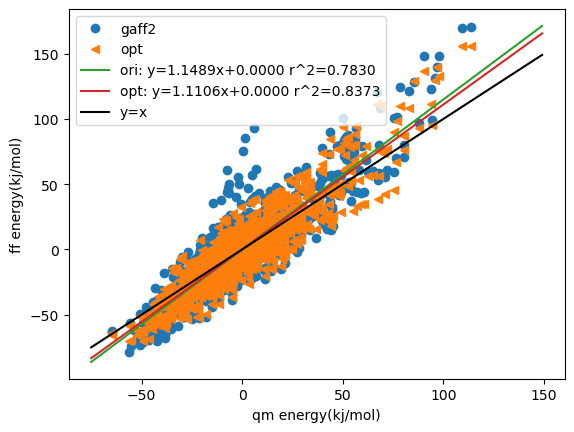

In [78]:

e_opt = np.array([i[0] for i in efg_opt])
e_ori = np.array([i[0] for i in efg_ori])
e_qm_ = mol_data["E"][:1000,0]*4.184
e_opt = e_opt - e_opt.mean()
e_ori = e_ori - e_ori.mean()
e_qm_ = e_qm_ - e_qm_.mean()

plt.plot(e_qm_, e_ori, marker="o", linestyle="", label='gaff2')
plt.plot(e_qm_, e_opt, marker="<", linestyle="", label='opt')

fit = linregress(e_qm_, e_ori)
label = f"ori: y={fit.slope:5.4f}x+{fit.intercept:5.4f} r^2={fit.rvalue**2:5.4f}"
plt.plot(np.arange(-75,150), fit.slope*np.arange(-75,150)+fit.intercept, label=label)

fit = linregress(e_qm_, e_opt)
label = f"opt: y={fit.slope:5.4f}x+{fit.intercept:5.4f} r^2={fit.rvalue**2:5.4f}"
plt.plot(np.arange(-75,150), fit.slope*np.arange(-75,150)+fit.intercept, label=label)

plt.plot(np.arange(-75,150), np.arange(-75,150),color="k", label="y=x")
plt.legend()
plt.xlabel("qm energy(kj/mol)")
plt.ylabel("ff energy(kj/mol)")

Text(0, 0.5, 'num')

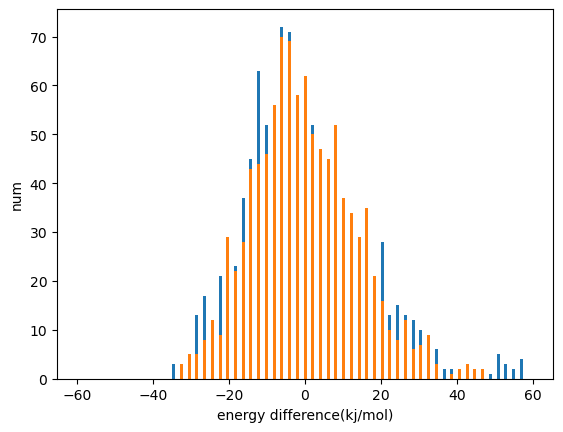

In [84]:
# the energy difference distribution of test set
bins = np.linspace(-60,60, 60)
bin_plot = (bins[:-1] + bins[1:])/2
num, bins = np.histogram(e_ori-e_qm_, bins=bins)
plt.bar(bin_plot, num, label="ori" )
num, bins = np.histogram(e_opt-e_qm_, bins=bins)
plt.bar(bin_plot, num, label="opt" )
plt.xlabel("energy difference(kj/mol)")
plt.ylabel("num")


Text(0, 0.5, 'num')

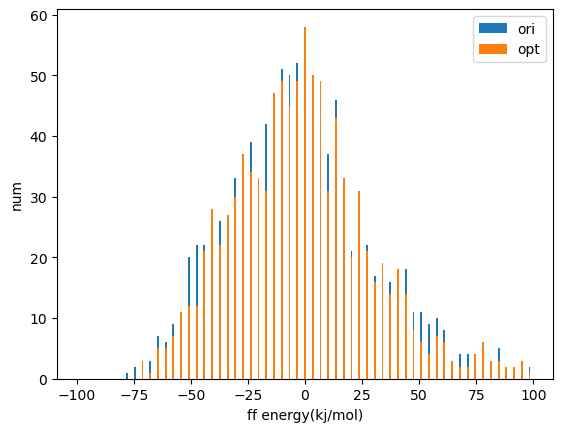

In [85]:
# the energy distribution of test set

bins = np.linspace(-100,100, 60)
bin_plot = (bins[:-1] + bins[1:])/2
num, bins = np.histogram(e_ori, bins=bins)
plt.bar(bin_plot, num, label="ori" )
num, bins = np.histogram(e_opt, bins=bins)
plt.bar(bin_plot, num, label="opt" )
plt.legend()
plt.xlabel("ff energy(kj/mol)")
plt.ylabel("num")
